In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

df_prescribers = pd.read_csv("pa2017.csv", dtype={'NPI': str})  # 1 row per dr
df_drugs = pd.read_csv("padrugs2017.csv", dtype={'NPI': str})  # 1 row per dr/drug
df_opioids = pd.read_csv("druggeographypa.csv", dtype={'Gnrc_Name': str})  # classify

df_drugs = df_drugs.merge(df_opioids, on="Gnrc_Name", how="left")  # Add opioid classification to drug data
df_opioids_only = df_drugs[df_drugs["Opioid_Drug_Flag"] == 'Y']  # Keep only opioid drugs

In [3]:
codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")
print(codes.columns)
df_opioids = codes[codes["pharmclas"].str.contains("opioid agonist", case=False, na=False)]
opioid_ndcs = df_opioids[["ndc"]].drop_duplicates()
opioid_ndcs.to_csv("opioid_ndcs.csv", index=False)
print("Opioid NDCs extracted and saved as 'opioid_ndcs.csv'")

Index(['prodid', 'ndc', 'prodtype', 'propname', 'propsuf', 'npropname',
       'dosename', 'routename', 'stmarkdatestr', 'stmarkdate',
       'endmarkdatestr', 'endmarkdate', 'markname', 'appnum', 'labelname',
       'subname', 'actnumstr', 'actingunit', 'pharmclas', 'deasched',
       'ndc_exclude_flag', 'listing_record_certstr', 'listing_record_cert'],
      dtype='object')
Opioid NDCs extracted and saved as 'opioid_ndcs.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1058/1712877063.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")


In [4]:
df_opioids_agg = df_opioids_only.groupby("Prscrbr_NPI").agg(
    Total_Opioid_Claims=("Tot_Clms_x", "sum"),  # Total opioid prescriptions per doctor
    Unique_Opioid_Drugs=("Gnrc_Name", "nunique")  # Number of distinct opioids prescribed
).reset_index()

df_merged = pd.merge(df_prescribers, df_opioids_agg, on="Prscrbr_NPI", how="left")
df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
df_merged["Unique_Opioid_Drugs"].fillna(0, inplace=True)

df_specialty_stats = df_merged.groupby("Prscrbr_Type")["Total_Opioid_Claims"].agg(['mean', 'std']).reset_index()
df_specialty_stats.rename(columns={'mean': 'Specialty_Mean_Opioid_Claims', 'std': 'Specialty_Std_Opioid_Claims'}, inplace=True)

df_merged = pd.merge(df_merged, df_specialty_stats, on="Prscrbr_Type", how="left")

df_merged["Opioid_Prescribing_ZScore"] = (df_merged["Total_Opioid_Claims"] - df_merged["Specialty_Mean_Opioid_Claims"]) / df_merged["Specialty_Std_Opioid_Claims"]
df_merged.to_csv("pa_merged_opioid_specialty_adjusted.csv", index=False)


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1058/1131647889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1058/1131647889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [5]:
df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str}) 
df_opioid_ndcs = pd.read_csv("opioid_ndcs.csv", dtype=str)
opioid_ndc_set = set(df_opioid_ndcs["ndc"].astype(str).str.strip())
def is_opioid_payment(row):
    for i in range(1, 6):  
        ndc = str(row.get(f"Associated_Drug_or_Biological_NDC_{i}", "")) 
        if any(opioid_ndc in ndc for opioid_ndc in opioid_ndc_set):  
            return True
    return False
df_payments["Is_Opioid_Payment"] = df_payments.apply(is_opioid_payment, axis=1)
df_opioid_payments = df_payments[df_payments["Is_Opioid_Payment"]]
df_opioid_payments.to_csv("opioid_payments_filtered.csv", index=False)
print("Filtered Open Payments data saved as 'opioid_payments_filtered.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1058/2791430706.py:1: DtypeWarning: Columns (4,10,15,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str})


Filtered Open Payments data saved as 'opioid_payments_filtered.csv'


In [6]:
df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})
df_network = df_opioid_payments.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Covered_Recipient_NPI"]).agg(
    Total_Opioid_Payments=("Total_Amount_of_Payment_USDollars", "sum")
).reset_index()
df_network.to_csv("pharma_prescriber_network_data.csv", index=False)
print("Aggregated network data saved as 'pharma_prescriber_network_data.csv'")

Aggregated network data saved as 'pharma_prescriber_network_data.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_1058/171572685.py:1: DtypeWarning: Columns (4,35,51,54,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})


In [7]:
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={'Covered_Recipient_NPI': str})
G = nx.DiGraph()
pharma_nodes = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
prescriber_nodes = df_network["Covered_Recipient_NPI"].unique()
G.add_nodes_from(pharma_nodes, bipartite=0)  # Group 0: Pharma companies
G.add_nodes_from(prescriber_nodes, bipartite=1)  # Group 1: Prescribers
for _, row in df_network.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], 
               row["Covered_Recipient_NPI"], 
               weight=row["Total_Opioid_Payments"])
nx.write_gml(G, "pharma_prescriber_network.gml")
print("Network constructed and saved as 'pharma_prescriber_network.gml'")

Network constructed and saved as 'pharma_prescriber_network.gml'


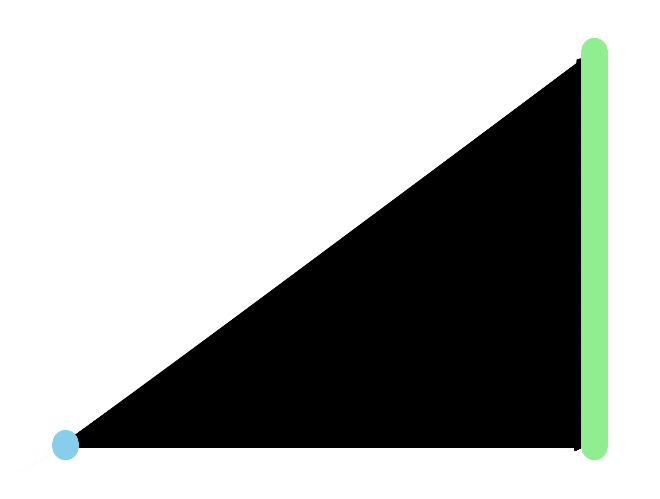

Total pharmaceutical companies: 24
Total doctors: 2026


In [ ]:
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

left_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
right_nodes = set(G) - left_nodes
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(left_nodes))
pos.update((n, (2, i)) for i, n in enumerate(right_nodes))
nx.draw(G, pos, with_labels=False, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()])
plt.show()

pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}

print(f"Total pharmaceutical companies: {len(pharma_nodes)}")
print(f"Total doctors: {len(doctor_nodes)}")

In [32]:
pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
centrality = bipartite.degree_centrality(G, pharma_nodes)
pharma_centrality = {n: c for n, c in centrality.items() if n in pharma_nodes}
for node, centrality_score in pharma_centrality.items():
    print(f"{node}: {centrality_score:.4f}")

Collegium Pharmaceutical, Inc.: 0.1422
Braeburn Pharmaceuticals, Inc.: 0.0395
Daiichi Sankyo Inc.: 0.1037
Endo Pharmaceuticals Inc.: 0.0015
Mission Pharmacal Company: 0.0104
Indivior Inc.: 0.1624
Vertical Pharmaceuticals, LLC: 0.0370
INSYS Therapeutics Inc: 0.0997
Purdue Pharma L.P.: 0.4768
Depomed, Inc.: 0.2878
Orexo US, Inc.: 0.0582
Mylan Institutional Inc.: 0.0039
Mallinckrodt LLC: 0.0010
Purdue Transdermal Technologies L.P.: 0.0005
The Medicines Company: 0.0138
BioDelivery Sciences International, Inc.: 0.0647
Egalet US Inc: 0.0582
Mylan Pharmaceuticals Inc.: 0.0123
Fresenius Kabi USA, LLC: 0.0005
Akrimax Pharmaceuticals, LLC: 0.0064
Mylan Specialty L.P.: 0.0227
Sentynl Therapeutics, Inc.: 0.0311
Pernix Therapeutics Holdings, Inc.: 0.1022
PFIZER INC.: 0.0933


In [33]:
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
centrality = bipartite.degree_centrality(G, doctor_nodes)
doctor_centrality = {n: c for n, c in centrality.items() if n in doctor_nodes}
df = pd.DataFrame.from_dict(doctor_centrality, orient='index', columns=['degree_centrality'])
df.index.name = 'doctor_id' 
df.to_csv("doctor_degree_centrality.csv")